In [2]:
!pip install mlflow torchinfo torch torchvision torchsummary opencv-python tqdm Pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

## Import lib

In [3]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

#PyTorch Monitoring to MLflow
import mlflow

Accessing the Dataset from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_path = '/content/drive/MyDrive/SDS-myconet/DeFungi/'
#root_path = 'E:\SDS\SDS-CP031-myconet\DeFungi'

## Create dataframe

In [7]:
#root_path = '/kaggle/input/defungi/'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_path_list = glob(img_path+'/*.jpg')
    for jpg_path in jpg_path_list:
        new_data_frame =pd.DataFrame({"path":jpg_path,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data_frame], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

Display DataFrame

In [8]:
df.head()

,path,label,class_id
0,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
1,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
2,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
3,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
4,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0


##Show Class Distribution

**Class distribution in histogram**

(array([4404.,    0., 2334.,    0.,    0.,  819.,    0.,  821.,    0.,
         739.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

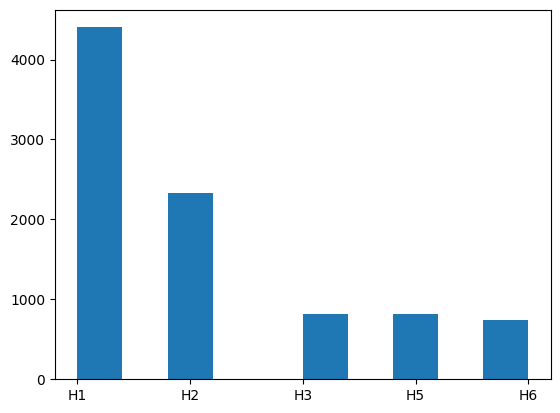

In [9]:
plt.hist(df['label'])

**Handling Class Imbalance**

Since our dataset is imbalanced and we want to use a weighted loss function, we will use the weight argument in PyTorch's loss functions like nn.CrossEntropyLoss. This allows us to assign different weights to the loss for each class, giving more importance to the minority classes.


In [10]:
# Calculate class frequencies
class_counts = df['class_id'].value_counts().sort_index()
total_samples = len(df)
class_weights = total_samples / (len(class_counts) * class_counts)

# Convert to a PyTorch tensor and move to the device
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
print("Class Weights:", class_weights_tensor)

Class Weights: tensor([0.4140, 0.7812, 2.2264, 2.2210, 2.4674], device='cuda:0')


## Display sample images from Dataset

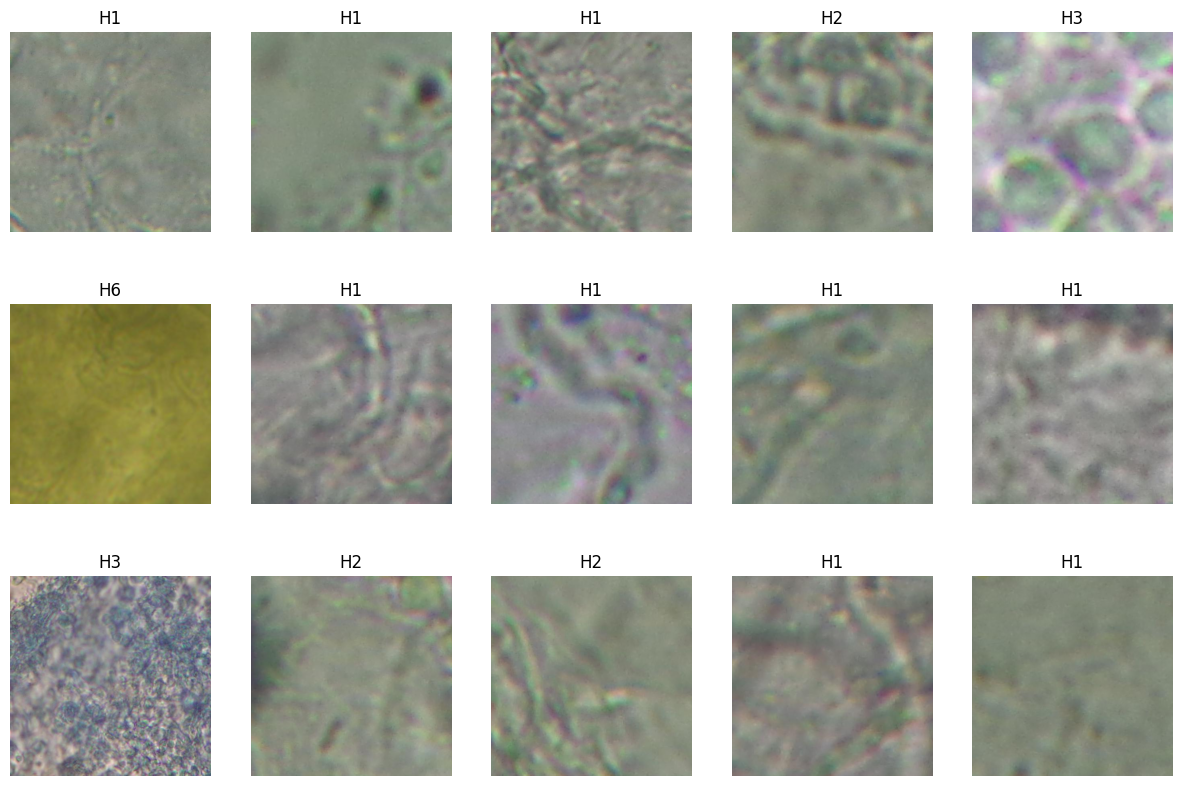

In [11]:
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Create Image Transformations

**Image Transformations Explained**
The code defines three sets of transformations using torchvision.transforms.v2.Compose:

train_transforms: These transformations are applied specifically to the images used for training the model. They include several data augmentation techniques to help the model generalize better and prevent overfitting.

eval_transforms: These transformations are for the validation set, which is used during training to evaluate the model's performance on data it hasn't seen before. Data augmentation is typically not applied here, only transformations needed to get the images into the correct format and size for the model.

test_transforms: These transformations are for the test set, which is used for a final evaluation of the trained model. Like the validation set, data augmentation is not applied here.

In [12]:
train_transforms = v2.Compose([
 v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_transforms = v2.Compose([
    v2.Resize((224,224)), # Resize to 224x224 (no cropping for evaluation)
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = v2.Compose([
    v2.Resize((224,224)), # Resize to 224x224 (no cropping for testing)
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

**Define Custom Dataset**

This code defines a custom dataset class called MyDataset which inherits from PyTorch's Dataset class [1]


In [13]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

**Create Dataset and Dataloader**

We use train_test_split twice. First, to split into training and a combined validation/test set, and then again to split the combined validation/test set into separate validation and test sets.

In [14]:
## Create dataset and dataloader

# Assuming 'df' dataframe is already created and contains 'label' column for stratification

# First split: 80% for training, 20% for combined validation and testing
train_df, val_test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=9898,
    stratify=df['label'] # Stratify based on the 'label' column
)

# Second split: Split the 20% (val_test_df) into 10% for validation and 10% for testing
# Since val_test_df is 20% of the original data, splitting it 50/50 will give 10% each
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5, # 0.5 of the 20% is 10% of the original data
    random_state=9898,
    stratify=val_test_df['label'] # Stratify this split as well
)


device = torch.device("cuda" if torch.cuda.is_available else "cpu")
# num_workers can be adjusted based on your system
num_workers = 2 if device=='cuda' else 2 # Example workers setting

# Create datasets for each split
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, eval_transforms) # Using eval_transforms for validation
test_dataset = MyDataset(test_df, test_transforms) # Using test_transforms for testing


BATCH_SIZE = 16

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers) # Test loader

In [15]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')
print(f'test data:{len(test_df)}')

train data:7293
val data:912
test data:912


## Create model

In [16]:
NUM_CLASSES=5

Define the custom CNN

In [17]:
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)  # out BS , 16, 222, 222
        self.Maxpool1 = nn.MaxPool2d(2, 2)   # out BS , 16, 111, 111
        self.conv2 = nn.Conv2d(16, 64, 3) # out BS , 64, 109, 109
        self.MaxPool2 = nn.MaxPool2d(2,2) # out BS , 64, 54, 54
        # Updated input features for fc1 based on the calculated flattened size (64 * 54 * 54)
        self.fc1 = nn.Linear(64*54*54, 128) # out: (BS, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x) # out: (BS, 16, 222, 222)
        x = self.relu(x)
        x = self.Maxpool1(x) # out: (BS, 16, 111, 111)
        x = self.conv2(x) # out: (BS, 64, 109, 109)
        x = self.relu(x)
        x = self.MaxPool2(x) # out: (BS, 64, 54, 54)
        x = x = torch.flatten(x, 1)   #Out after  BS, 64*54*54
        x = self.fc1(x)     # BS ,128
        x = self.relu(x)
        x = self.fc2(x)     # BS, 64
        x = self.relu(x)
        x = self.fc3(x)     #BS , NUM_CLASSES
        #x = self.softmax(x)
        return x

## Initialize the Model

In [18]:
class_size = 5
model = ImageMulticlassClassificationNet()

# Determine the input size for the fully connected layer
# We will pass a dummy tensor through the convolutional and pooling layers
# to see the output shape before the flattening step.
dummy_input = torch.randn((16, 3, 224, 224)) # Use the expected input size after transforms

# Pass the dummy input through the conv and pooling layers
with torch.no_grad(): # We don't need to calculate gradients for this
    x = model.conv1(dummy_input)
    x = model.relu(x)
    x = model.Maxpool1(x)
    x = model.conv2(x)
    x = model.relu(x)
    x = model.MaxPool2(x)
    flattened_size = x.view(x.size(0), -1).size(1) # Get the size after flattening



In [19]:
x.shape

torch.Size([16, 64, 54, 54])

In [20]:
print(f'Flattened size: {flattened_size}')

Flattened size: 186624


In [21]:
# Now define the fully connected layer with the determined input size
#model.fc = nn.Linear(flattened_size, class_size)
model

ImageMulticlassClassificationNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

## Training and Validation

In [22]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)

        # First we'll clean the cache of optimizer
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(data_)

        # Computing loss
        loss = criterion(outputs,target_)

        # Backward propagation
        loss.backward()

        # Optimizing model
        optimizer.step()

        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def eval(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)

            # Computing loss
            loss = criterion(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

def test(dataloader, model, loss_fn):
      size = len(dataloader.dataset)
      num_batches = len(dataloader)
      model.eval() # Set the model to evaluation mode
      test_loss = 0.0
      correct = 0
      all_labels = []
      all_predictions = []

      with torch.no_grad():
        for data, target in dataloader:
            target = target.type(torch.LongTensor)
            data, target = data.to(device), target.to(device)

            # Forward pass
            outputs = model(data)
            loss = loss_fn(outputs, target)

            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()

            # Store labels and predictions for metrics calculation
            all_labels.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

      test_loss /= num_batches
      accuracy = correct / size

      # Calculate additional metrics
      from sklearn.metrics import f1_score, recall_score, confusion_matrix

      f1 = f1_score(all_labels, all_predictions, average='weighted') # Use weighted average for imbalance
      recall = recall_score(all_labels, all_predictions, average='weighted') # Use weighted average for imbalance
      cm = confusion_matrix(all_labels, all_predictions)

      return accuracy, test_loss, f1, recall, cm

In [23]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

#Initialize the loss function and apply the class weights:
#Pass the class_weights_tensor to the weight argument of the torch.nn.CrossEntropyLoss function.

criterion  = nn.CrossEntropyLoss(weight=class_weights_tensor)


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

# Start the main MLflow run that covers the entire training and evaluation process
with mlflow.start_run():
    # Log parameters at the beginning of the run
    mlflow.log_params({
        "epochs": EPOCHS,
        "learning_rate": learning_rate,
        "optimizer": type(optimizer).__name__,
        "loss_function": type(criterion).__name__,
        "batch_size": BATCH_SIZE,
        "device": str(device),
        "lr_milestones": lr_milestones,
        "lr_gamma": 0.1,
        "early_stopping_patience": patience
        # Add any other relevant parameters you've defined
    })

    # Log model architecture as an artifact
    model_summary_file = "model_summary.txt"
    with open(model_summary_file, "w") as f:
        f.write(str(torchsummary.summary(model, input_size=(3, 224, 224), device=str(device))))
    mlflow.log_artifact(model_summary_file)
    os.remove(model_summary_file) # Clean up the temporary file


    for epoch in tqdm(range(EPOCHS)):
        train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
        val_acc, val_loss = eval(val_loader, model, criterion)
        print(f'EPOCH: {epoch} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
        Learning Rate: {optimizer.param_groups[0]["lr"]}')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

        # Log metrics for each epoch within the same run
        mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "learning_rate": optimizer.param_groups[0]["lr"]
            }, step=epoch)

        # Save model checkpoints
        torch.save(model.state_dict(), "last.pth")

        # Log checkpoint every few epochs (e.g., every 10 epochs) as an artifact (optional)
        if (epoch + 1) % 1 == 0:
            checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            mlflow.log_artifact(checkpoint_path, artifact_path="checkpoints")
            os.remove(checkpoint_path) # Clean up the temporary file


        # chcek improvement
        if val_loss < best_loss:
            counter = 0
            best_loss = val_loss
            torch.save(model.state_dict(), "best.pth")
        else:
            counter += 1
        if counter >= patience:
            print("Earlystop!")
            break

    # --- Test Evaluation and Logging (inside the main MLflow run) ---
    print("\n--- Evaluating on Test Set ---")

    # Load the best model state dictionary
    model.load_state_dict(torch.load("best.pth"))
    model.to(device) # Ensure the model is on the correct device

    test_accuracy, test_loss, test_f1, test_recall, test_confusion_matrix = test(test_loader, model, criterion)

    print("\n--- Test Set Results ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print("\nConfusion Matrix:")
    print(test_confusion_matrix)

    # Log test metrics to the same MLflow run
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1_score", test_f1)
    mlflow.log_metric("test_recall", test_recall)
    # Log confusion matrix as an artifact (requires saving it to a file)
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 8))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    confusion_matrix_path = "confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    mlflow.log_artifact(confusion_matrix_path)
    os.remove(confusion_matrix_path) # Clean up the temporary file
    plt.close() # Close the plot

    # The MLflow run automatically ends when exiting this 'with' block

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
              ReLU-2         [-1, 16, 222, 222]               0
         MaxPool2d-3         [-1, 16, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]           9,280
              ReLU-5         [-1, 64, 109, 109]               0
         MaxPool2d-6           [-1, 64, 54, 54]               0
            Linear-7                  [-1, 128]      23,888,000
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 5]             325
Total params: 23,906,309
Trainable params: 23,906,309
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0         train_loss: 6.6886, train_acc: 0.366         val_loss: 1.0784, val_acc: 0.594         Learning Rate: 0.0001


  2%|▏         | 1/50 [54:29<44:30:26, 3269.94s/it]

EPOCH: 1         train_loss: 1.2951, train_acc: 0.488         val_loss: 1.0904, val_acc: 0.595         Learning Rate: 0.0001


  4%|▍         | 2/50 [55:44<18:32:13, 1390.29s/it]

EPOCH: 2         train_loss: 1.1891, train_acc: 0.532         val_loss: 1.1091, val_acc: 0.588         Learning Rate: 0.0001


  6%|▌         | 3/50 [56:58<10:18:16, 789.29s/it] 

EPOCH: 3         train_loss: 1.1353, train_acc: 0.547         val_loss: 1.0758, val_acc: 0.529         Learning Rate: 0.0001


  8%|▊         | 4/50 [58:13<6:28:51, 507.20s/it] 

EPOCH: 4         train_loss: 1.1358, train_acc: 0.546         val_loss: 1.0897, val_acc: 0.532         Learning Rate: 0.0001


 10%|█         | 5/50 [59:26<4:23:05, 350.79s/it]

EPOCH: 5         train_loss: 1.1143, train_acc: 0.555         val_loss: 1.0198, val_acc: 0.560         Learning Rate: 0.0001


 12%|█▏        | 6/50 [1:00:40<3:08:11, 256.63s/it]

EPOCH: 6         train_loss: 1.0915, train_acc: 0.560         val_loss: 0.9829, val_acc: 0.592         Learning Rate: 1e-05


 14%|█▍        | 7/50 [1:01:55<2:21:21, 197.24s/it]

EPOCH: 7         train_loss: 1.0243, train_acc: 0.583         val_loss: 0.9150, val_acc: 0.625         Learning Rate: 1e-05


 16%|█▌        | 8/50 [1:03:09<1:50:30, 157.86s/it]

EPOCH: 8         train_loss: 0.9922, train_acc: 0.588         val_loss: 0.9019, val_acc: 0.633         Learning Rate: 1e-05


 18%|█▊        | 9/50 [1:04:23<1:30:01, 131.74s/it]

EPOCH: 9         train_loss: 0.9847, train_acc: 0.593         val_loss: 0.9076, val_acc: 0.633         Learning Rate: 1e-05


 20%|██        | 10/50 [1:05:35<1:15:35, 113.39s/it]

EPOCH: 10         train_loss: 0.9766, train_acc: 0.599         val_loss: 0.8915, val_acc: 0.627         Learning Rate: 1e-05


 22%|██▏       | 11/50 [1:06:48<1:05:42, 101.08s/it]

EPOCH: 11         train_loss: 0.9540, train_acc: 0.597         val_loss: 0.8709, val_acc: 0.643         Learning Rate: 1e-05


 24%|██▍       | 12/50 [1:08:02<58:47, 92.83s/it]   

EPOCH: 12         train_loss: 0.9594, train_acc: 0.599         val_loss: 0.8993, val_acc: 0.594         Learning Rate: 1e-05


 26%|██▌       | 13/50 [1:09:16<53:39, 87.00s/it]

EPOCH: 13         train_loss: 0.9680, train_acc: 0.598         val_loss: 0.8661, val_acc: 0.645         Learning Rate: 1.0000000000000002e-06


 28%|██▊       | 14/50 [1:10:32<50:08, 83.57s/it]

EPOCH: 14         train_loss: 0.9450, train_acc: 0.600         val_loss: 0.8575, val_acc: 0.635         Learning Rate: 1.0000000000000002e-06


 30%|███       | 15/50 [1:11:46<47:03, 80.68s/it]

EPOCH: 15         train_loss: 0.9398, train_acc: 0.601         val_loss: 0.8643, val_acc: 0.626         Learning Rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [1:13:01<44:46, 79.01s/it]

EPOCH: 16         train_loss: 0.9380, train_acc: 0.599         val_loss: 0.8607, val_acc: 0.632         Learning Rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [1:14:16<42:48, 77.83s/it]

EPOCH: 17         train_loss: 0.9322, train_acc: 0.596         val_loss: 0.8563, val_acc: 0.622         Learning Rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [1:15:31<41:08, 77.14s/it]

EPOCH: 18         train_loss: 0.9371, train_acc: 0.600         val_loss: 0.8590, val_acc: 0.637         Learning Rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [1:16:46<39:28, 76.40s/it]

EPOCH: 19         train_loss: 0.9292, train_acc: 0.604         val_loss: 0.8565, val_acc: 0.632         Learning Rate: 1.0000000000000002e-06


 40%|████      | 20/50 [1:18:00<37:52, 75.73s/it]

EPOCH: 20         train_loss: 0.9339, train_acc: 0.602         val_loss: 0.8545, val_acc: 0.630         Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [1:19:16<36:39, 75.84s/it]

EPOCH: 21         train_loss: 0.9315, train_acc: 0.603         val_loss: 0.8540, val_acc: 0.630         Learning Rate: 1.0000000000000002e-07


 44%|████▍     | 22/50 [1:20:34<35:41, 76.48s/it]

EPOCH: 22         train_loss: 0.9269, train_acc: 0.600         val_loss: 0.8547, val_acc: 0.629         Learning Rate: 1.0000000000000002e-07


 46%|████▌     | 23/50 [1:21:49<34:12, 76.01s/it]

EPOCH: 23         train_loss: 0.9297, train_acc: 0.601         val_loss: 0.8537, val_acc: 0.629         Learning Rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [1:23:06<33:02, 76.23s/it]

EPOCH: 24         train_loss: 0.9318, train_acc: 0.603         val_loss: 0.8549, val_acc: 0.629         Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [1:24:21<31:33, 75.75s/it]

EPOCH: 25         train_loss: 0.9206, train_acc: 0.606         val_loss: 0.8555, val_acc: 0.627         Learning Rate: 1.0000000000000002e-07


 52%|█████▏    | 26/50 [1:25:37<30:22, 75.92s/it]

EPOCH: 26         train_loss: 0.9317, train_acc: 0.601         val_loss: 0.8552, val_acc: 0.628         Learning Rate: 1.0000000000000002e-07


 54%|█████▍    | 27/50 [1:26:54<29:14, 76.26s/it]

EPOCH: 27         train_loss: 0.9216, train_acc: 0.599         val_loss: 0.8557, val_acc: 0.630         Learning Rate: 1.0000000000000004e-08


 56%|█████▌    | 28/50 [1:28:11<28:00, 76.40s/it]

EPOCH: 28         train_loss: 0.9257, train_acc: 0.602         val_loss: 0.8556, val_acc: 0.630         Learning Rate: 1.0000000000000004e-08


 56%|█████▌    | 28/50 [1:29:24<1:10:14, 191.58s/it]

Earlystop!

--- Evaluating on Test Set ---



--- Test Set Results ---
Test Loss: 0.9090
Test Accuracy: 0.5976
Test F1 Score: 0.5977
Test Recall: 0.5976

Confusion Matrix:
[[296  69  71   2   2]
 [ 91  72  43   9  19]
 [ 14   4  54   9   1]
 [  1   3   4  63  11]
 [  1   1   8   4  60]]


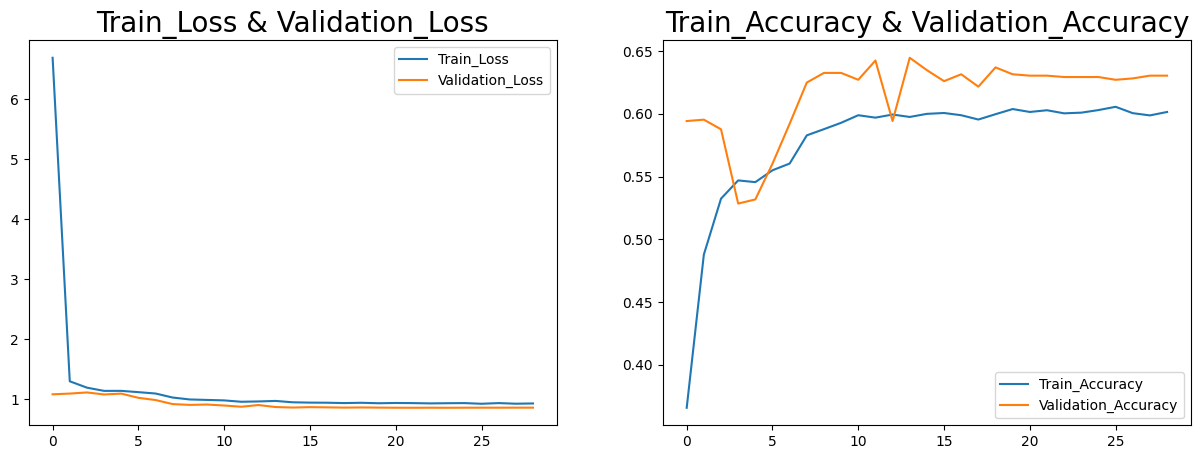

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [25]:
## Evaluate on the Test Set and Output Metrics

# Load the best model state dictionary
model.load_state_dict(torch.load("best.pth"))
model.to(device) # Ensure the model is on the correct device

test_accuracy, test_loss, test_f1, test_recall, test_confusion_matrix = test(test_loader, model, criterion)

print("\n--- Test Set Results ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print("\nConfusion Matrix:")
print(test_confusion_matrix)

# Optionally, log test metrics to MLflow
with mlflow.start_run():
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1_score", test_f1)
    mlflow.log_metric("test_recall", test_recall)
    # You might want to log the confusion matrix as an artifact
    # For simplicity, we'll just print it here. Logging it requires
    # saving it to a file or image.


--- Test Set Results ---
Test Loss: 0.9090
Test Accuracy: 0.5976
Test F1 Score: 0.5977
Test Recall: 0.5976

Confusion Matrix:
[[296  69  71   2   2]
 [ 91  72  43   9  19]
 [ 14   4  54   9   1]
 [  1   3   4  63  11]
 [  1   1   8   4  60]]
